In [1]:
# attaching kaggle account 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sumeet13gupta","key":"2b3c7e86c16abdb5aaa300401827ca88"}'}

In [2]:
# insttall the kaggle api client
!pip install -q kaggle

In [3]:
# Kaggle API client expects this file to be in ~/.kaggle, so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#this permission change avoids a warning on Kaggle startup
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1652          6  0.1764706        


In [6]:
!kaggle datasets download catherinehorng/dogbreedidfromcomp

100% 689M/691M [00:18<00:00, 38.7MB/s]
100% 691M/691M [00:18<00:00, 38.6MB/s]


In [7]:
# Unzipping downloaded files and removing useless files
!dir
!unzip dogbreedidfromcomp.zip -d dog_dataset
!rm dogbreedidfromcomp.zip
!rm sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: dog_dataset/train/840dbad5

Now we start building the Model
we will use the following layers in our network architecture i.e. CNN(Convulutional Neural Network):
Dense, Dropout, Flatten, Conv2D, MaxPool2D 

We will be using a sequential Model : Adam

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

Data Preprocessing

In [9]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()
print(breed_counts.shape)
print(list(breeds_all))




(120,)
['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'bluetick', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'otterhound', 'bedlington_terrier', 'dingo', 'golden_retriever', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'walker_hound', 'weimaraner', 'giant_schnauzer', 'golden_retriever', 'boston_bull', 'groenendael', 'lakeland_terrier', 'irish_water_spaniel', 'dhole', 'dingo', 'affenpinscher', 'toy_poodle', 'border_terrier', 'lakeland_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'african_hunting_dog', 'irish_water_spaniel', 'walker_hound', 'irish_water_spaniel', 'wire-haired_fox_terrier', 'giant_schnauzer', 'affenpinscher', '

In [11]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [12]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))


100%|██████████| 357/357 [00:01<00:00, 280.73it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


# Building the model 

In [23]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)      

After defining the Network Architecture we found total number of arameters as 162,619

Next we will create a network architecture for the model. We have used different types of layers according to their features namely 

Conv_2D : It is used to create a convolutional Kernel that is convolved with the Input Layer to produce an Output Tensor), 

max_pooling2d : it is a downsampling techinique which takes out the maximum value over the window defined by the pool size,

Flatten : It flattens the input and creates a 1D output

Dense : Dense Layer produce the output as the dot product of input and kernel

For Compilation of a model. you need to configure the learning process before training the model. This is done via Compile method
The compile method requires three arguments ⁉
-> An Optimizer : This could be a string optimizer of an existing optimizer( rmsprop, adagrad, adom, etc) or an instance of the Optimizer class.

-> A loss function : This is the objective that the model will try to miniize. It can be a string identifier of an existing Loss function( such as categorical_crossentropuy, or mse, or binary_crossentropy)
For multi-class classification problem => categorical_crossentropy

-> A list of metric : For any classification problem you will want to set this to metric = ['accuracy']



In [24]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

after network architecture definition, we will split the test and train data and then Train data into train and validation data

In [25]:
# Training the model
import time
epochs = 100
batch_size = 128
t1 = time.time()
MyDogClassifier = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))
t2 = time.time()
print("Time taken : ", t2-t1)

Epoch 1/100
2/2 [==============================] - 2s 639ms/step - loss: 4.9173 - accuracy: 0.3242 - val_loss: 4.9075 - val_accuracy: 0.2154
Epoch 2/100
2/2 [==============================] - 1s 405ms/step - loss: 4.8877 - accuracy: 0.3125 - val_loss: 4.8747 - val_accuracy: 0.2154
Epoch 3/100
2/2 [==============================] - 1s 395ms/step - loss: 4.8640 - accuracy: 0.3320 - val_loss: 4.8468 - val_accuracy: 0.2923
Epoch 4/100
2/2 [==============================] - 1s 394ms/step - loss: 4.8401 - accuracy: 0.3555 - val_loss: 4.8204 - val_accuracy: 0.4000
Epoch 5/100
2/2 [==============================] - 1s 401ms/step - loss: 4.8144 - accuracy: 0.4141 - val_loss: 4.7950 - val_accuracy: 0.4154
Epoch 6/100
2/2 [==============================] - 1s 398ms/step - loss: 4.7889 - accuracy: 0.4531 - val_loss: 4.7726 - val_accuracy: 0.3846
Epoch 7/100
2/2 [==============================] - 1s 396ms/step - loss: 4.7642 - accuracy: 0.4688 - val_loss: 4.7512 - val_accuracy: 0.3385
Epoch 8/100
2

Lets plot the accuracy of the model


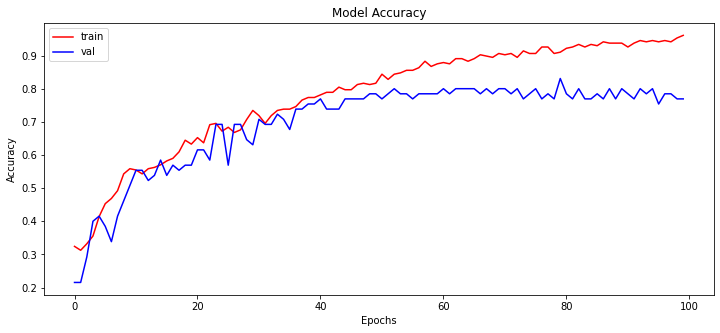

In [27]:
# Plot the training History

plt.figure(figsize=(12, 5))
plt.plot(MyDogClassifier.history['accuracy'], color='r')
plt.plot(MyDogClassifier.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()


Here we analyse how the model is learning with each epoch , in terms of accuracy

In [28]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 12ms/step - loss: 2.9745 - accuracy: 0.8889
Accuracy over the test set: 
  88.89 %


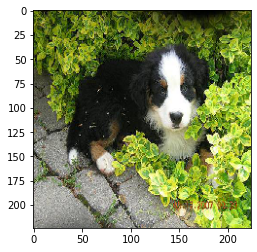

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [29]:
# Plotting Image to compare
plt.imshow(X_test[0,:,:,:])
plt.show()

#Finding max value from prediction list and comparing original value vs predicted
print("Originally : ", labels['breed'][np.argmax(Y_test[0])])
print("Predicted : ", labels['breed'][np.argmax(Y_pred[0])])

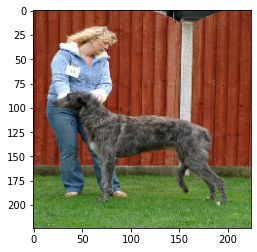

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [30]:
# Plotting Image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

#Finding max value from prediction list and comparing original value vs predicted
print("Originally : ", labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ", labels['breed'][np.argmax(Y_pred[1])])

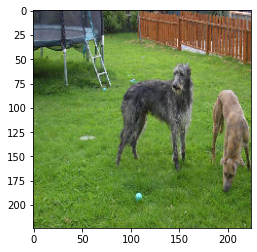

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [31]:
# Plotting Image to compare
plt.imshow(X_test[2,:,:,:])
plt.show()

#Finding max value from prediction list and comparing original value vs predicted
print("Originally : ", labels['breed'][np.argmax(Y_test[2])])
print("Predicted : ", labels['breed'][np.argmax(Y_pred[2])])

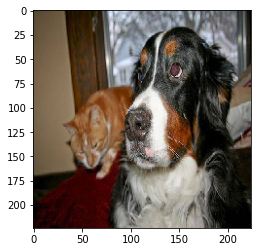

Originally :  scottish_deerhound
Predicted :  maltese_dog


In [32]:
# Plotting Image to compare
plt.imshow(X_test[5,:,:,:])
plt.show()

#Finding max value from prediction list and comparing original value vs predicted
print("Originally : ", labels['breed'][np.argmax(Y_test[5])])
print("Predicted : ", labels['breed'][np.argmax(Y_pred[5])])

In [33]:
for i in range(len(Y_pred)):
  print(labels['breed'][np.argmax(Y_test[i])],"\t\t -> ",labels['breed'][np.argmax(Y_pred[i])])


scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
maltese_dog 		 ->  maltese_dog
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  maltese_dog
maltese_dog 		 ->  maltese_dog
maltese_dog 		 ->  maltese_dog
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
maltese_dog 		 ->  maltese_dog
maltese_dog 		 ->  maltese_dog
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  maltese_dog
scottish_deerhound 		 ->  scottish_deerhound
maltese_dog 		 ->  maltese_dog
maltese_dog 		 ->  maltese_dog
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  scottish_deerhound
scottish_deerhound 		 ->  maltese_dog
scottish_deerhound 		 ->  scottish_deer

# Conclusion

We started with downloading the dataset creating the model and finding out the predictions using the model. We can optimize different hyper parameters in order to tune this model for a higher accuracy. This model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purposes also.